In [1]:
import torch
from torch.utils.data import Dataset
from torchvision import datasets

from utils.data import *

device = "cuda" if torch.cuda.is_available() else "cpu"
print(device)

%load_ext autoreload
%autoreload 2

cuda


# DATA

In [2]:
TRAIN_FLAG = True
#DATA_SET = 'Shapes'
DATA_SET = 'Circles'
#DATA_SET = 'MNIST'

In [3]:
import matplotlib.pyplot as plt

def plot_grid(data, grid_size=4):
    mat_data = data.data if hasattr(data, 'data') else data

    _, ax = plt.subplots(nrows=grid_size, ncols=grid_size, figsize=(8,8))

    for i in range(grid_size):
        for j in range(grid_size):
            ax[i][j].imshow(mat_data[i*grid_size+j].movedim(0, 2), cmap='gray')
            ax[i][j].axis('off')
    plt.tight_layout(pad=0.5)

[[  0  97]
 [  1 103]]
(200, 1, 28, 28)
torch.Size([157, 1, 28, 28]) torch.Size([40, 1, 28, 28])
tensor(0.) tensor(1.)
CPU times: user 421 ms, sys: 100 ms, total: 521 ms
Wall time: 407 ms


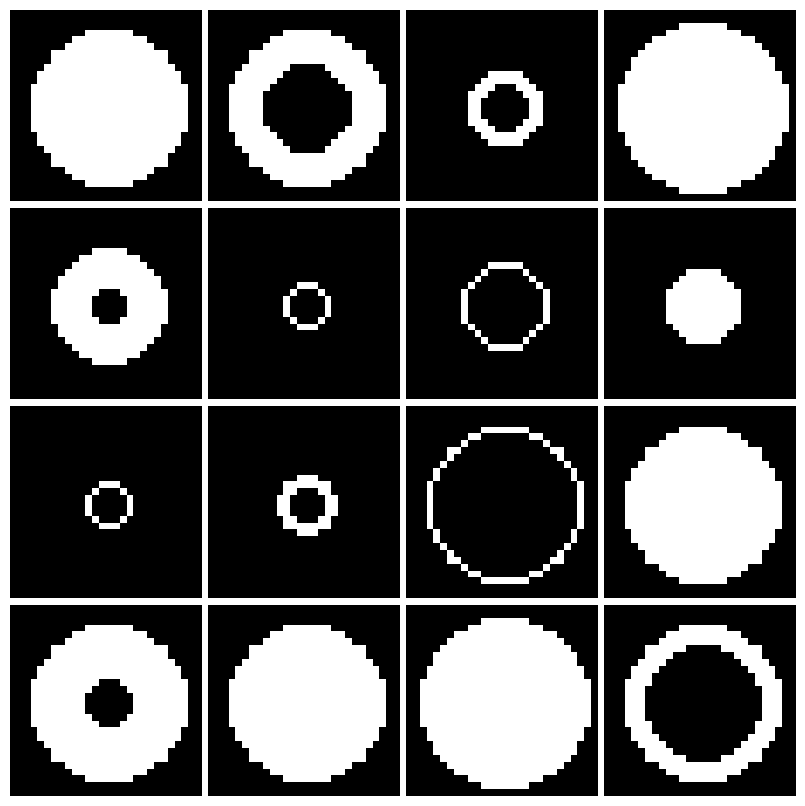

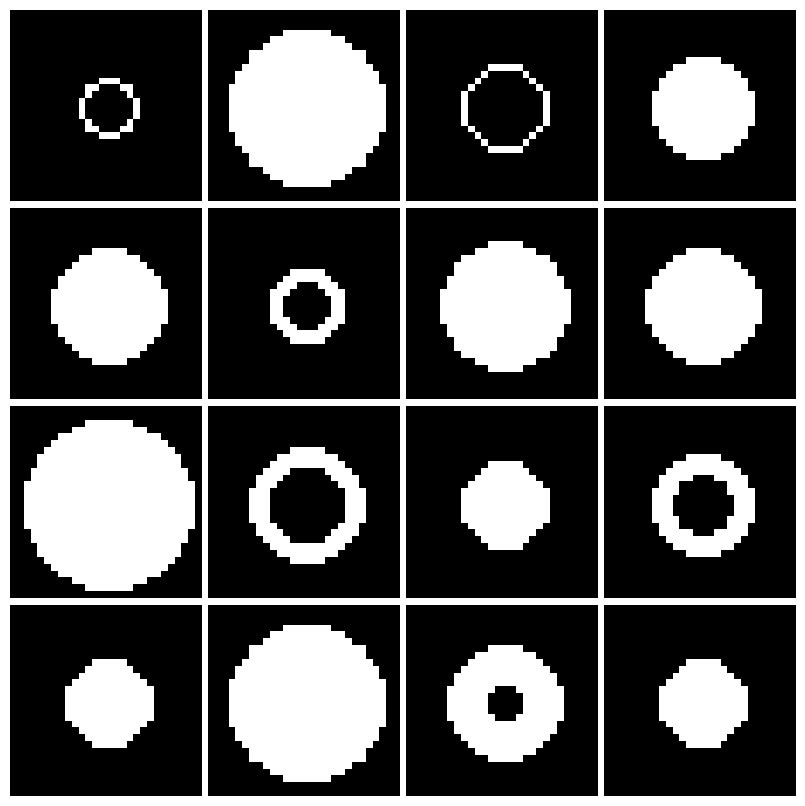

In [4]:
%%time

if DATA_SET == 'Circles' :
    shapes, targets = gen_circles_dataset(num_images=200, seed=42)
    print(np.array(np.unique(targets, return_counts=True)).T)
    
    shapes = shapes.reshape(-1, 1, 28, 28) / 255.
    print(shapes.shape)

    subsampled_indeces = sample_indices(targets, k=100, max_classes=None, seed=42)
    train_indeces = random.sample(subsampled_indeces, int(0.8*len(subsampled_indeces)))
    test_indeces = list(set(subsampled_indeces)-set(train_indeces))
        
    train_dataset = torch.from_numpy(shapes[train_indeces].astype(np.float32))
    eval_dataset = torch.from_numpy(shapes[test_indeces].astype(np.float32))

    train_labels = targets[train_indeces]
    eval_labels = targets[test_indeces]

elif DATA_SET == 'Shapes' :
    shapes, targets = load_shapes_dataset()
    shapes = 1 - shapes.reshape(-1, 1, 28, 28) / 255.
    print(shapes.shape)

    # train_indeces = sample_indices(targets, k=90, seed=42)
    # remaining_indeces = list(set(range(len(targets)))-set(train_indeces))
    # test_indeces = sample_indices(targets[remaining_indeces], k=10, seed=42)
    subsampled_indeces = sample_indices(targets, k=100, max_classes=2, seed=42)
    train_indeces = random.sample(subsampled_indeces, int(0.8*len(subsampled_indeces)))
    test_indeces = list(set(subsampled_indeces)-set(train_indeces))
        
    train_dataset = torch.from_numpy(shapes[train_indeces].astype(np.float32))
    eval_dataset = torch.from_numpy(shapes[test_indeces].astype(np.float32))

    train_labels = targets[train_indeces]
    eval_labels = targets[test_indeces]

elif DATA_SET == 'MNIST' :
    mnist_trainset = datasets.MNIST(root='./data', train=True, download=True, transform=None)

    # train_indeces = sample_indices(mnist_trainset.targets, k=500, max_classes=2, seed=42)
    # remaining_indeces = list(set(range(len(mnist_trainset.targets)))-set(train_indeces))
    # test_indeces = sample_indices(mnist_trainset.targets[remaining_indeces], k=50, seed=42)

    subsampled_indeces = sample_indices(mnist_trainset.targets, k=1000, max_classes=2, seed=42)
    train_indeces = random.sample(subsampled_indeces, int(0.8*len(subsampled_indeces)))
    test_indeces = list(set(subsampled_indeces)-set(train_indeces))

    train_dataset = mnist_trainset.data[train_indeces].reshape(-1, 1, 28, 28) / 255.
    eval_dataset = mnist_trainset.data[test_indeces].reshape(-1, 1, 28, 28) / 255.

    train_labels = mnist_trainset.targets[train_indeces]
    eval_labels = mnist_trainset.targets[test_indeces]

print(train_dataset.shape, eval_dataset.shape)
print(train_dataset.min(), train_dataset.max())

plot_grid(train_dataset)
plot_grid(eval_dataset)

In [5]:
print(train_dataset.shape, train_dataset.min(), train_dataset.max(), train_dataset.mean(), train_dataset.std())
print(eval_dataset.shape, eval_dataset.min(), eval_dataset.max(), eval_dataset.mean(), eval_dataset.std())

torch.Size([157, 1, 28, 28]) tensor(0.) tensor(1.) tensor(0.2111) tensor(0.4081)
torch.Size([40, 1, 28, 28]) tensor(0.) tensor(1.) tensor(0.2741) tensor(0.4461)


In [6]:
# train_mean, train_std = train_dataset.mean(), train_dataset.std()
# train_dataset -= train_mean / train_std
# eval_dataset -= train_mean / train_std

# TRAIN

## Configure Training

In [7]:
from pythae.models import *
from pythae.models.nn.benchmarks.mnist import *
from pythae.models.nn.default_architectures import *
from pythae.models.base.base_utils import ModelOutput
from utils.models import Encoder_VAE_TinyMLP, Decoder_AE_TinyMLP

architecture_dict = {
    'tiny':
        {
        'encoder': Encoder_VAE_TinyMLP,
        'decoder': Decoder_AE_TinyMLP,
        },
    'mlp':
        {
        'encoder': Encoder_VAE_MLP,
        'decoder': Decoder_AE_MLP,
        },
    'convnet':
        {
        'encoder': Encoder_Conv_VAE_MNIST,
        'decoder': Decoder_Conv_AE_MNIST,
        },
    'resnet':
        {
        'encoder': Encoder_ResNet_VAE_MNIST,
        'decoder': Decoder_ResNet_AE_MNIST,
        },
    }

In [8]:
model_config = RHVAEConfig(
    input_dim=(1, 28, 28),
    latent_dim=2,
    reconstruction_loss="bce",
    n_lf=3,
    eps_lf=1e-3,
    beta_zero=0.3,
    temperature=0.8,
    regularization=1e-3
)

model = RHVAE(
    model_config=model_config,
    encoder=architecture_dict['tiny']['encoder'](model_config),
    decoder=architecture_dict['tiny']['decoder'](model_config),
)

# model_config = VAEConfig(
#     input_dim=(1, 28, 28),
#     latent_dim=2,
#     reconstruction_loss="bce",
# )

# model = VAE(
#     model_config=model_config,
#     encoder=architecture_dict['tiny']['encoder'](model_config),
#     decoder=architecture_dict['tiny']['decoder'](model_config),
# )

In [9]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

%time count_parameters(model)

CPU times: user 72 µs, sys: 23 µs, total: 95 µs
Wall time: 97.3 µs


946391

In [10]:
print(model)

RHVAE(
  (decoder): Decoder_AE_TinyMLP(
    (layers): Sequential(
      (0): Linear(in_features=2, out_features=400, bias=True)
      (1): ReLU()
      (2): Linear(in_features=400, out_features=784, bias=True)
      (3): Sigmoid()
    )
  )
  (encoder): Encoder_VAE_TinyMLP(
    (layers): Sequential(
      (0): Flatten(start_dim=1, end_dim=-1)
      (1): Linear(in_features=784, out_features=400, bias=True)
      (2): ReLU()
    )
    (embedding): Linear(in_features=400, out_features=2, bias=True)
    (log_var): Linear(in_features=400, out_features=2, bias=True)
  )
  (metric): Metric_MLP(
    (layers): Sequential(
      (0): Linear(in_features=784, out_features=400, bias=True)
      (1): ReLU()
    )
    (diag): Linear(in_features=400, out_features=2, bias=True)
    (lower): Linear(in_features=400, out_features=1, bias=True)
  )
)


## Train

In [11]:
%%time

from pythae.trainers import BaseTrainerConfig, BaseTrainer
from pythae.trainers.training_callbacks import TrainHistoryCallback
from pythae.pipelines.training import TrainingPipeline

training_config = BaseTrainerConfig(
    output_dir='experiments',
    num_epochs=200,
    learning_rate=1e-3,
    per_device_train_batch_size=len(train_dataset),
    per_device_eval_batch_size=len(eval_dataset),
    #optimizer_cls="AdamW",
    #optimizer_params={"weight_decay": 0.05, "betas": (0.91, 0.99)},
    scheduler_cls="ReduceLROnPlateau",
    scheduler_params={"patience": 10, "factor": 0.5, "verbose": True}
)

pipeline = TrainingPipeline(
        training_config=training_config,
        model=model
)

callbacks = []
history_cb = TrainHistoryCallback()
callbacks.append(history_cb)

if TRAIN_FLAG:
    pipeline(
        train_data=train_dataset,
        eval_data=eval_dataset,
        callbacks=callbacks
    )
else:
    pass

Preprocessing train data...
Checking train dataset...
Preprocessing eval data...

Checking eval dataset...
Using Base Trainer

Model passed sanity check !
Ready for training.

Created experiments/RHVAE_training_2024-06-10_13-50-24. 
Training config, checkpoints and final model will be saved here.

Training params:
 - max_epochs: 200
 - per_device_train_batch_size: 157
 - per_device_eval_batch_size: 40
 - checkpoint saving every: None
Optimizer: Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: None
    lr: 0.001
    maximize: False
    weight_decay: 0
)
Scheduler: <torch.optim.lr_scheduler.ReduceLROnPlateau object at 0x7feaa40601f0>

Successfully launched training !



Training of epoch 1/200:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 1/200:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 568.7605
Eval loss: 528.1254
--------------------------------------------------------------------------


Training of epoch 2/200:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 2/200:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 531.0169
Eval loss: 505.4461
--------------------------------------------------------------------------


Training of epoch 3/200:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 3/200:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 504.6458
Eval loss: 464.6011
--------------------------------------------------------------------------


Training of epoch 4/200:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 4/200:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 476.2096
Eval loss: 438.2982
--------------------------------------------------------------------------


Training of epoch 5/200:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 5/200:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 449.3901
Eval loss: 419.4803
--------------------------------------------------------------------------


Training of epoch 6/200:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 6/200:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 425.3168
Eval loss: 399.2073
--------------------------------------------------------------------------


Training of epoch 7/200:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 7/200:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 391.6371
Eval loss: 349.6495
--------------------------------------------------------------------------


Training of epoch 8/200:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 8/200:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 366.0972
Eval loss: 325.2906
--------------------------------------------------------------------------


Training of epoch 9/200:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 9/200:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 347.3051
Eval loss: 337.4519
--------------------------------------------------------------------------


Training of epoch 10/200:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 10/200:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 333.4216
Eval loss: 325.906
--------------------------------------------------------------------------


Training of epoch 11/200:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 11/200:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 318.1202
Eval loss: 284.7042
--------------------------------------------------------------------------


Training of epoch 12/200:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 12/200:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 304.5195
Eval loss: 268.5481
--------------------------------------------------------------------------


Training of epoch 13/200:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 13/200:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 288.6223
Eval loss: 290.1106
--------------------------------------------------------------------------


Training of epoch 14/200:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 14/200:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 281.4433
Eval loss: 285.4234
--------------------------------------------------------------------------


Training of epoch 15/200:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 15/200:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 275.0185
Eval loss: 239.2706
--------------------------------------------------------------------------


Training of epoch 16/200:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 16/200:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 255.3555
Eval loss: 235.5524
--------------------------------------------------------------------------


Training of epoch 17/200:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 17/200:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 239.6618
Eval loss: 235.6395
--------------------------------------------------------------------------


Training of epoch 18/200:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 18/200:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 235.4743
Eval loss: 240.6364
--------------------------------------------------------------------------


Training of epoch 19/200:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 19/200:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 217.2332
Eval loss: 214.4515
--------------------------------------------------------------------------


Training of epoch 20/200:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 20/200:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 211.1072
Eval loss: 222.5641
--------------------------------------------------------------------------


Training of epoch 21/200:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 21/200:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 198.027
Eval loss: 205.0066
--------------------------------------------------------------------------


Training of epoch 22/200:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 22/200:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 195.0529
Eval loss: 192.452
--------------------------------------------------------------------------


Training of epoch 23/200:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 23/200:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 187.7458
Eval loss: 189.9172
--------------------------------------------------------------------------


Training of epoch 24/200:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 24/200:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 177.5998
Eval loss: 175.0683
--------------------------------------------------------------------------


Training of epoch 25/200:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 25/200:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 174.1296
Eval loss: 169.9938
--------------------------------------------------------------------------


Training of epoch 26/200:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 26/200:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 163.8164
Eval loss: 162.1684
--------------------------------------------------------------------------


Training of epoch 27/200:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 27/200:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 156.2953
Eval loss: 156.6937
--------------------------------------------------------------------------


Training of epoch 28/200:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 28/200:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 150.8634
Eval loss: 151.4302
--------------------------------------------------------------------------


Training of epoch 29/200:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 29/200:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 146.3063
Eval loss: 148.9932
--------------------------------------------------------------------------


Training of epoch 30/200:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 30/200:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 144.8402
Eval loss: 142.4054
--------------------------------------------------------------------------


Training of epoch 31/200:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 31/200:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 137.8579
Eval loss: 139.8599
--------------------------------------------------------------------------


Training of epoch 32/200:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 32/200:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 134.2877
Eval loss: 134.2091
--------------------------------------------------------------------------


Training of epoch 33/200:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 33/200:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 129.2448
Eval loss: 130.2534
--------------------------------------------------------------------------


Training of epoch 34/200:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 34/200:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 126.1678
Eval loss: 128.5509
--------------------------------------------------------------------------


Training of epoch 35/200:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 35/200:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 123.7595
Eval loss: 124.532
--------------------------------------------------------------------------


Training of epoch 36/200:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 36/200:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 120.4205
Eval loss: 118.5465
--------------------------------------------------------------------------


Training of epoch 37/200:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 37/200:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 116.1108
Eval loss: 116.1227
--------------------------------------------------------------------------


Training of epoch 38/200:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 38/200:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 112.7299
Eval loss: 114.4013
--------------------------------------------------------------------------


Training of epoch 39/200:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 39/200:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 109.6766
Eval loss: 109.0545
--------------------------------------------------------------------------


Training of epoch 40/200:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 40/200:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 104.4901
Eval loss: 106.8421
--------------------------------------------------------------------------


Training of epoch 41/200:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 41/200:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 102.6583
Eval loss: 104.1817
--------------------------------------------------------------------------


Training of epoch 42/200:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 42/200:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 100.3482
Eval loss: 104.2452
--------------------------------------------------------------------------


Training of epoch 43/200:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 43/200:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 97.6854
Eval loss: 99.4501
--------------------------------------------------------------------------


Training of epoch 44/200:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 44/200:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 96.417
Eval loss: 97.9768
--------------------------------------------------------------------------


Training of epoch 45/200:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 45/200:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 92.6278
Eval loss: 95.9785
--------------------------------------------------------------------------


Training of epoch 46/200:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 46/200:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 90.7457
Eval loss: 94.2145
--------------------------------------------------------------------------


Training of epoch 47/200:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 47/200:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 88.3153
Eval loss: 94.7066
--------------------------------------------------------------------------


Training of epoch 48/200:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 48/200:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 88.3954
Eval loss: 92.1452
--------------------------------------------------------------------------


Training of epoch 49/200:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 49/200:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 88.6289
Eval loss: 91.8371
--------------------------------------------------------------------------


Training of epoch 50/200:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 50/200:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 85.7889
Eval loss: 90.6328
--------------------------------------------------------------------------


Training of epoch 51/200:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 51/200:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 83.8356
Eval loss: 90.0173
--------------------------------------------------------------------------


Training of epoch 52/200:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 52/200:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 83.2316
Eval loss: 88.447
--------------------------------------------------------------------------


Training of epoch 53/200:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 53/200:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 80.9624
Eval loss: 87.2681
--------------------------------------------------------------------------


Training of epoch 54/200:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 54/200:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 80.0127
Eval loss: 84.6691
--------------------------------------------------------------------------


Training of epoch 55/200:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 55/200:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 79.0542
Eval loss: 86.2004
--------------------------------------------------------------------------


Training of epoch 56/200:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 56/200:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 78.543
Eval loss: 85.0879
--------------------------------------------------------------------------


Training of epoch 57/200:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 57/200:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 77.947
Eval loss: 83.5457
--------------------------------------------------------------------------


Training of epoch 58/200:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 58/200:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 76.6511
Eval loss: 82.1754
--------------------------------------------------------------------------


Training of epoch 59/200:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 59/200:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 76.1831
Eval loss: 80.5551
--------------------------------------------------------------------------


Training of epoch 60/200:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 60/200:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 75.8211
Eval loss: 79.505
--------------------------------------------------------------------------


Training of epoch 61/200:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 61/200:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 73.9492
Eval loss: 79.7312
--------------------------------------------------------------------------


Training of epoch 62/200:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 62/200:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 74.7605
Eval loss: 80.5988
--------------------------------------------------------------------------


Training of epoch 63/200:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 63/200:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 72.2063
Eval loss: 80.2442
--------------------------------------------------------------------------


Training of epoch 64/200:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 64/200:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 71.9642
Eval loss: 77.4579
--------------------------------------------------------------------------


Training of epoch 65/200:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 65/200:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 71.6302
Eval loss: 76.867
--------------------------------------------------------------------------


Training of epoch 66/200:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 66/200:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 71.1223
Eval loss: 76.3739
--------------------------------------------------------------------------


Training of epoch 67/200:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 67/200:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 70.7609
Eval loss: 76.2166
--------------------------------------------------------------------------


Training of epoch 68/200:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 68/200:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 69.6152
Eval loss: 74.6433
--------------------------------------------------------------------------


Training of epoch 69/200:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 69/200:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 69.3418
Eval loss: 75.9319
--------------------------------------------------------------------------


Training of epoch 70/200:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 70/200:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 69.4789
Eval loss: 71.9029
--------------------------------------------------------------------------


Training of epoch 71/200:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 71/200:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 67.3484
Eval loss: 76.2518
--------------------------------------------------------------------------


Training of epoch 72/200:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 72/200:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 68.2115
Eval loss: 73.3986
--------------------------------------------------------------------------


Training of epoch 73/200:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 73/200:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 66.4812
Eval loss: 72.3276
--------------------------------------------------------------------------


Training of epoch 74/200:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 74/200:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 66.0462
Eval loss: 70.8649
--------------------------------------------------------------------------


Training of epoch 75/200:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 75/200:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 65.3932
Eval loss: 68.4221
--------------------------------------------------------------------------


Training of epoch 76/200:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 76/200:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 65.7489
Eval loss: 68.9337
--------------------------------------------------------------------------


Training of epoch 77/200:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 77/200:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 65.162
Eval loss: 68.3548
--------------------------------------------------------------------------


Training of epoch 78/200:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 78/200:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 64.6944
Eval loss: 68.3587
--------------------------------------------------------------------------


Training of epoch 79/200:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 79/200:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 63.539
Eval loss: 68.4715
--------------------------------------------------------------------------


Training of epoch 80/200:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 80/200:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 64.5189
Eval loss: 67.1391
--------------------------------------------------------------------------


Training of epoch 81/200:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 81/200:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 62.9742
Eval loss: 65.6153
--------------------------------------------------------------------------


Training of epoch 82/200:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 82/200:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 63.3704
Eval loss: 67.4952
--------------------------------------------------------------------------


Training of epoch 83/200:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 83/200:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 62.0695
Eval loss: 66.2669
--------------------------------------------------------------------------


Training of epoch 84/200:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 84/200:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 62.0311
Eval loss: 65.4218
--------------------------------------------------------------------------


Training of epoch 85/200:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 85/200:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 62.4016
Eval loss: 62.6198
--------------------------------------------------------------------------


Training of epoch 86/200:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 86/200:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 60.9515
Eval loss: 64.1037
--------------------------------------------------------------------------


Training of epoch 87/200:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 87/200:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 60.4958
Eval loss: 67.275
--------------------------------------------------------------------------


Training of epoch 88/200:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 88/200:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 60.4654
Eval loss: 62.6175
--------------------------------------------------------------------------


Training of epoch 89/200:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 89/200:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 59.7799
Eval loss: 61.8641
--------------------------------------------------------------------------


Training of epoch 90/200:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 90/200:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 59.7311
Eval loss: 61.9585
--------------------------------------------------------------------------


Training of epoch 91/200:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 91/200:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 59.5307
Eval loss: 60.7794
--------------------------------------------------------------------------


Training of epoch 92/200:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 92/200:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 60.055
Eval loss: 61.3511
--------------------------------------------------------------------------


Training of epoch 93/200:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 93/200:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 58.5408
Eval loss: 60.0216
--------------------------------------------------------------------------


Training of epoch 94/200:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 94/200:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 58.6236
Eval loss: 60.0692
--------------------------------------------------------------------------


Training of epoch 95/200:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 95/200:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 57.7331
Eval loss: 59.6388
--------------------------------------------------------------------------


Training of epoch 96/200:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 96/200:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 57.5749
Eval loss: 58.9215
--------------------------------------------------------------------------


Training of epoch 97/200:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 97/200:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 57.3254
Eval loss: 59.5456
--------------------------------------------------------------------------


Training of epoch 98/200:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 98/200:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 56.9623
Eval loss: 57.6715
--------------------------------------------------------------------------


Training of epoch 99/200:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 99/200:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 56.1161
Eval loss: 57.2442
--------------------------------------------------------------------------


Training of epoch 100/200:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 100/200:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 56.4836
Eval loss: 57.0292
--------------------------------------------------------------------------


Training of epoch 101/200:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 101/200:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 55.8008
Eval loss: 57.3955
--------------------------------------------------------------------------


Training of epoch 102/200:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 102/200:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 55.0531
Eval loss: 58.7592
--------------------------------------------------------------------------


Training of epoch 103/200:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 103/200:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 55.2505
Eval loss: 56.3195
--------------------------------------------------------------------------


Training of epoch 104/200:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 104/200:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 55.0135
Eval loss: 57.2956
--------------------------------------------------------------------------


Training of epoch 105/200:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 105/200:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 54.086
Eval loss: 55.3597
--------------------------------------------------------------------------


Training of epoch 106/200:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 106/200:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 53.9031
Eval loss: 54.8311
--------------------------------------------------------------------------


Training of epoch 107/200:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 107/200:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 53.5585
Eval loss: 55.4019
--------------------------------------------------------------------------


Training of epoch 108/200:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 108/200:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 54.0923
Eval loss: 54.7532
--------------------------------------------------------------------------


Training of epoch 109/200:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 109/200:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 53.7258
Eval loss: 55.3825
--------------------------------------------------------------------------


Training of epoch 110/200:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 110/200:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 52.4626
Eval loss: 55.3087
--------------------------------------------------------------------------


Training of epoch 111/200:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 111/200:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 52.9046
Eval loss: 54.2121
--------------------------------------------------------------------------


Training of epoch 112/200:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 112/200:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 52.1218
Eval loss: 55.0291
--------------------------------------------------------------------------


Training of epoch 113/200:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 113/200:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 51.3642
Eval loss: 52.9117
--------------------------------------------------------------------------


Training of epoch 114/200:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 114/200:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 51.3484
Eval loss: 52.4743
--------------------------------------------------------------------------


Training of epoch 115/200:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 115/200:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 51.7125
Eval loss: 52.8415
--------------------------------------------------------------------------


Training of epoch 116/200:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 116/200:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 51.8733
Eval loss: 51.926
--------------------------------------------------------------------------


Training of epoch 117/200:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 117/200:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 51.2152
Eval loss: 52.2825
--------------------------------------------------------------------------


Training of epoch 118/200:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 118/200:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 50.2046
Eval loss: 50.6141
--------------------------------------------------------------------------


Training of epoch 119/200:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 119/200:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 50.4846
Eval loss: 51.4464
--------------------------------------------------------------------------


Training of epoch 120/200:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 120/200:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 50.241
Eval loss: 50.4985
--------------------------------------------------------------------------


Training of epoch 121/200:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 121/200:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 49.5232
Eval loss: 51.2126
--------------------------------------------------------------------------


Training of epoch 122/200:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 122/200:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 49.5462
Eval loss: 49.9676
--------------------------------------------------------------------------


Training of epoch 123/200:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 123/200:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 49.3197
Eval loss: 50.0358
--------------------------------------------------------------------------


Training of epoch 124/200:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 124/200:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 49.0334
Eval loss: 49.5971
--------------------------------------------------------------------------


Training of epoch 125/200:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 125/200:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 48.0887
Eval loss: 49.3168
--------------------------------------------------------------------------


Training of epoch 126/200:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 126/200:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 48.6146
Eval loss: 49.837
--------------------------------------------------------------------------


Training of epoch 127/200:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 127/200:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 48.5463
Eval loss: 49.391
--------------------------------------------------------------------------


Training of epoch 128/200:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 128/200:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 47.6878
Eval loss: 47.9002
--------------------------------------------------------------------------


Training of epoch 129/200:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 129/200:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 47.7818
Eval loss: 48.7194
--------------------------------------------------------------------------


Training of epoch 130/200:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 130/200:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 47.5577
Eval loss: 49.3845
--------------------------------------------------------------------------


Training of epoch 131/200:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 131/200:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 46.6211
Eval loss: 48.6308
--------------------------------------------------------------------------


Training of epoch 132/200:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 132/200:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 47.3624
Eval loss: 47.989
--------------------------------------------------------------------------


Training of epoch 133/200:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 133/200:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 46.9597
Eval loss: 48.1875
--------------------------------------------------------------------------


Training of epoch 134/200:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 134/200:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 46.4018
Eval loss: 47.5854
--------------------------------------------------------------------------


Training of epoch 135/200:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 135/200:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 46.266
Eval loss: 47.375
--------------------------------------------------------------------------


Training of epoch 136/200:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 136/200:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 46.4361
Eval loss: 46.6283
--------------------------------------------------------------------------


Training of epoch 137/200:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 137/200:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 45.4429
Eval loss: 46.9293
--------------------------------------------------------------------------


Training of epoch 138/200:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 138/200:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 45.2181
Eval loss: 47.7445
--------------------------------------------------------------------------


Training of epoch 139/200:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 139/200:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 45.2624
Eval loss: 48.252
--------------------------------------------------------------------------


Training of epoch 140/200:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 140/200:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 45.0526
Eval loss: 46.1069
--------------------------------------------------------------------------


Training of epoch 141/200:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 141/200:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 44.859
Eval loss: 45.7084
--------------------------------------------------------------------------


Training of epoch 142/200:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 142/200:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 44.4693
Eval loss: 45.3947
--------------------------------------------------------------------------


Training of epoch 143/200:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 143/200:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 44.6582
Eval loss: 45.5871
--------------------------------------------------------------------------


Training of epoch 144/200:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 144/200:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 44.9086
Eval loss: 44.5919
--------------------------------------------------------------------------


Training of epoch 145/200:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 145/200:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 44.2009
Eval loss: 46.2731
--------------------------------------------------------------------------


Training of epoch 146/200:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 146/200:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 43.8487
Eval loss: 45.1467
--------------------------------------------------------------------------


Training of epoch 147/200:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 147/200:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 43.7236
Eval loss: 44.7211
--------------------------------------------------------------------------


Training of epoch 148/200:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 148/200:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 43.7822
Eval loss: 44.0266
--------------------------------------------------------------------------


Training of epoch 149/200:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 149/200:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 42.934
Eval loss: 43.7032
--------------------------------------------------------------------------


Training of epoch 150/200:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 150/200:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 42.791
Eval loss: 44.2142
--------------------------------------------------------------------------


Training of epoch 151/200:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 151/200:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 42.7504
Eval loss: 44.746
--------------------------------------------------------------------------


Training of epoch 152/200:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 152/200:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 43.1123
Eval loss: 44.2942
--------------------------------------------------------------------------


Training of epoch 153/200:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 153/200:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 42.0409
Eval loss: 43.2862
--------------------------------------------------------------------------


Training of epoch 154/200:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 154/200:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 42.4441
Eval loss: 44.4428
--------------------------------------------------------------------------


Training of epoch 155/200:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 155/200:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 41.9803
Eval loss: 43.0942
--------------------------------------------------------------------------


Training of epoch 156/200:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 156/200:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 41.8836
Eval loss: 43.1687
--------------------------------------------------------------------------


Training of epoch 157/200:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 157/200:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 41.6232
Eval loss: 42.4699
--------------------------------------------------------------------------


Training of epoch 158/200:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 158/200:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 41.4564
Eval loss: 42.3085
--------------------------------------------------------------------------


Training of epoch 159/200:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 159/200:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 41.2439
Eval loss: 42.6608
--------------------------------------------------------------------------


Training of epoch 160/200:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 160/200:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 40.4305
Eval loss: 42.8818
--------------------------------------------------------------------------


Training of epoch 161/200:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 161/200:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 40.3022
Eval loss: 41.436
--------------------------------------------------------------------------


Training of epoch 162/200:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 162/200:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 40.6893
Eval loss: 41.2932
--------------------------------------------------------------------------


Training of epoch 163/200:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 163/200:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 40.7548
Eval loss: 42.231
--------------------------------------------------------------------------


Training of epoch 164/200:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 164/200:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 40.509
Eval loss: 41.4741
--------------------------------------------------------------------------


Training of epoch 165/200:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 165/200:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 39.7488
Eval loss: 40.8079
--------------------------------------------------------------------------


Training of epoch 166/200:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 166/200:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 39.8971
Eval loss: 41.8281
--------------------------------------------------------------------------


Training of epoch 167/200:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 167/200:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 39.7237
Eval loss: 40.8245
--------------------------------------------------------------------------


Training of epoch 168/200:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 168/200:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 39.9087
Eval loss: 40.1228
--------------------------------------------------------------------------


Training of epoch 169/200:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 169/200:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 39.1406
Eval loss: 40.4092
--------------------------------------------------------------------------


Training of epoch 170/200:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 170/200:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 39.7391
Eval loss: 40.2239
--------------------------------------------------------------------------


Training of epoch 171/200:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 171/200:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 39.1208
Eval loss: 40.1384
--------------------------------------------------------------------------


Training of epoch 172/200:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 172/200:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 38.7302
Eval loss: 40.0824
--------------------------------------------------------------------------


Training of epoch 173/200:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 173/200:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 38.6314
Eval loss: 40.361
--------------------------------------------------------------------------


Training of epoch 174/200:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 174/200:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 38.3061
Eval loss: 40.0507
--------------------------------------------------------------------------


Training of epoch 175/200:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 175/200:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 38.1308
Eval loss: 39.2777
--------------------------------------------------------------------------


Training of epoch 176/200:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 176/200:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 37.8391
Eval loss: 39.3253
--------------------------------------------------------------------------


Training of epoch 177/200:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 177/200:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 38.1209
Eval loss: 39.2226
--------------------------------------------------------------------------


Training of epoch 178/200:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 178/200:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 37.9412
Eval loss: 38.3595
--------------------------------------------------------------------------


Training of epoch 179/200:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 179/200:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 37.5723
Eval loss: 38.4319
--------------------------------------------------------------------------


Training of epoch 180/200:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 180/200:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 37.4987
Eval loss: 38.5267
--------------------------------------------------------------------------


Training of epoch 181/200:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 181/200:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 37.2384
Eval loss: 38.6951
--------------------------------------------------------------------------


Training of epoch 182/200:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 182/200:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 37.0229
Eval loss: 38.4489
--------------------------------------------------------------------------


Training of epoch 183/200:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 183/200:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 36.858
Eval loss: 37.8394
--------------------------------------------------------------------------


Training of epoch 184/200:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 184/200:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 36.9687
Eval loss: 38.1242
--------------------------------------------------------------------------


Training of epoch 185/200:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 185/200:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 36.9514
Eval loss: 37.9461
--------------------------------------------------------------------------


Training of epoch 186/200:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 186/200:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 36.0413
Eval loss: 37.5165
--------------------------------------------------------------------------


Training of epoch 187/200:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 187/200:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 36.289
Eval loss: 38.1558
--------------------------------------------------------------------------


Training of epoch 188/200:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 188/200:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 35.8142
Eval loss: 36.8168
--------------------------------------------------------------------------


Training of epoch 189/200:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 189/200:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 35.7718
Eval loss: 36.5244
--------------------------------------------------------------------------


Training of epoch 190/200:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 190/200:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 35.7578
Eval loss: 36.7275
--------------------------------------------------------------------------


Training of epoch 191/200:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 191/200:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 35.579
Eval loss: 36.8882
--------------------------------------------------------------------------


Training of epoch 192/200:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 192/200:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 35.8688
Eval loss: 37.1274
--------------------------------------------------------------------------


Training of epoch 193/200:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 193/200:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 35.2048
Eval loss: 36.766
--------------------------------------------------------------------------


Training of epoch 194/200:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 194/200:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 35.4596
Eval loss: 36.333
--------------------------------------------------------------------------


Training of epoch 195/200:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 195/200:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 34.8474
Eval loss: 36.6793
--------------------------------------------------------------------------


Training of epoch 196/200:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 196/200:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 35.1453
Eval loss: 36.6529
--------------------------------------------------------------------------


Training of epoch 197/200:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 197/200:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 35.0901
Eval loss: 36.1263
--------------------------------------------------------------------------


Training of epoch 198/200:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 198/200:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 34.9625
Eval loss: 36.0174
--------------------------------------------------------------------------


Training of epoch 199/200:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 199/200:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 34.694
Eval loss: 35.675
--------------------------------------------------------------------------


Training of epoch 200/200:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 200/200:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 34.1894
Eval loss: 36.1764
--------------------------------------------------------------------------
Training ended!
Saved final model in experiments/RHVAE_training_2024-06-10_13-50-24/final_model


CPU times: user 36.9 s, sys: 897 ms, total: 37.8 s
Wall time: 38.8 s


## Loss History

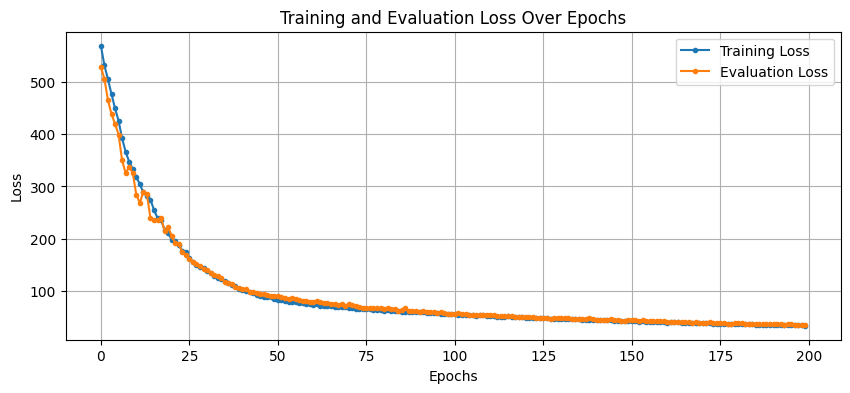

In [27]:
# Create the plot
plt.figure(figsize=(10, 4))
plt.plot(history_cb.history['train_loss'], label='Training Loss', marker='.')
plt.plot(history_cb.history['eval_loss'], label='Evaluation Loss', marker='.')

# Add titles and labels
plt.title('Training and Evaluation Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
#plt.yscale('log')
plt.legend()

# Show the plot
plt.grid(True)
plt.show()

## Trained Model

In [13]:
from pythae.models import AutoModel

if TRAIN_FLAG:
    trained_model = model
else:
    trained_model = AutoModel.load_from_folder(glob.glob('experiments/*/final_model')[0])
    #trained_model = AutoModel.load_from_hf_hub(hf_hub_path="clementchadebec/reproduced_vae", allow_pickle=True)

# LATENT SPACE

In [14]:
# latents = trained_model.encoder(eval_dataset.to(device)).embedding.detach().cpu().numpy()

# plt.figure(figsize=(8, 6))
# scatter = plt.scatter(latents[:, 0], latents[:, 1], c=eval_labels, cmap='viridis', marker='o')
# legend = plt.legend(*scatter.legend_elements(), title="Classes")


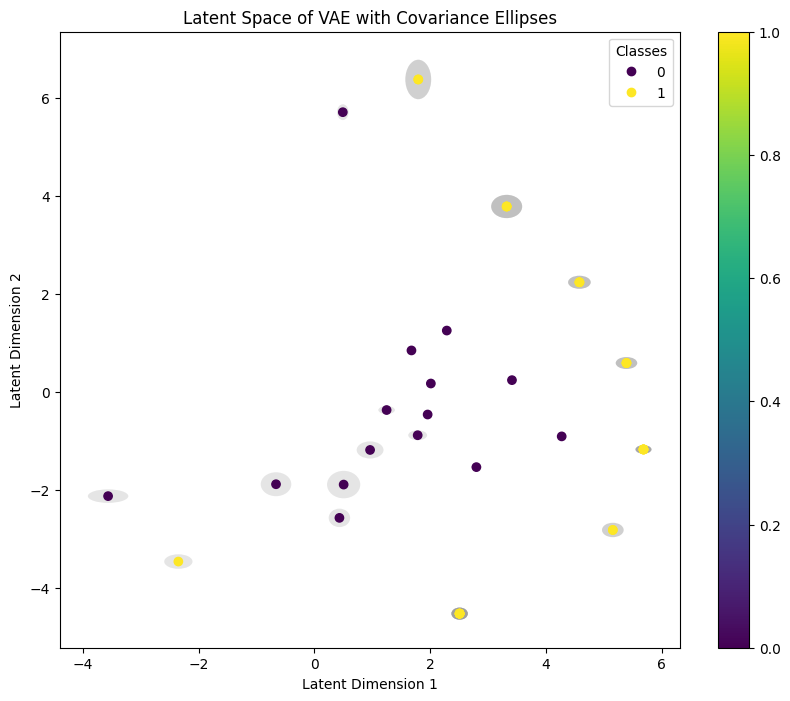

In [15]:
# Extract latent space representations
z_mean = trained_model.encoder(eval_dataset.to(device)).embedding.detach().cpu().numpy()
z_log_var = trained_model.encoder(eval_dataset.to(device)).log_covariance.detach().cpu().numpy()
y_test = eval_labels

# Plotting the latent space
def plot_cov_ellipse(mean, cov, ax, color='gray', nstd=1.0, **kwargs):
    """Plots an ellipse representing the covariance matrix."""
    from matplotlib.patches import Ellipse
    import matplotlib.transforms as transforms
    
    pearson = cov[0, 1] / np.sqrt(cov[0, 0] * cov[1, 1])
    ell_radius_x = np.sqrt(1 + pearson)
    ell_radius_y = np.sqrt(1 - pearson)
    ellipse = Ellipse((0, 0), width=ell_radius_x * 2, height=ell_radius_y * 2, facecolor=color, edgecolor='none', **kwargs)
    
    scale_x = np.sqrt(cov[0, 0]) * nstd
    scale_y = np.sqrt(cov[1, 1]) * nstd
    transf = transforms.Affine2D().rotate_deg(45).scale(scale_x, scale_y).translate(mean[0], mean[1])
    
    ellipse.set_transform(transf + ax.transData)
    ax.add_patch(ellipse)

fig, ax = plt.subplots(figsize=(10, 8))

# Plot covariance ellipses
for i in range(len(z_mean)):
    cov = np.diag(np.exp(z_log_var[i]))
    plot_cov_ellipse(z_mean[i], cov, ax, color='gray', alpha=0.2)
    
scatter = ax.scatter(z_mean[:, 0], z_mean[:, 1], c=y_test, cmap='viridis', alpha=1)
legend = plt.legend(*scatter.legend_elements(), title="Classes")

plt.colorbar(scatter, ax=ax)
ax.set_xlabel('Latent Dimension 1')
ax.set_ylabel('Latent Dimension 2')
ax.set_title('Latent Space of VAE with Covariance Ellipses')
plt.show()

In [16]:
trained_model
# 'centroids',
 # 'centroids_tens', 
 # 'metric', 
 # 'G',
 # 'G_inv',
 # 'M',
 # 'M_tens',
 # 'T_destination',

RHVAE(
  (decoder): Decoder_AE_TinyMLP(
    (layers): Sequential(
      (0): Linear(in_features=2, out_features=400, bias=True)
      (1): ReLU()
      (2): Linear(in_features=400, out_features=784, bias=True)
      (3): Sigmoid()
    )
  )
  (encoder): Encoder_VAE_TinyMLP(
    (layers): Sequential(
      (0): Flatten(start_dim=1, end_dim=-1)
      (1): Linear(in_features=784, out_features=400, bias=True)
      (2): ReLU()
    )
    (embedding): Linear(in_features=400, out_features=2, bias=True)
    (log_var): Linear(in_features=400, out_features=2, bias=True)
  )
  (metric): Metric_MLP(
    (layers): Sequential(
      (0): Linear(in_features=784, out_features=400, bias=True)
      (1): ReLU()
    )
    (diag): Linear(in_features=400, out_features=2, bias=True)
    (lower): Linear(in_features=400, out_features=1, bias=True)
  )
)

# RECONSTRUCTIONS

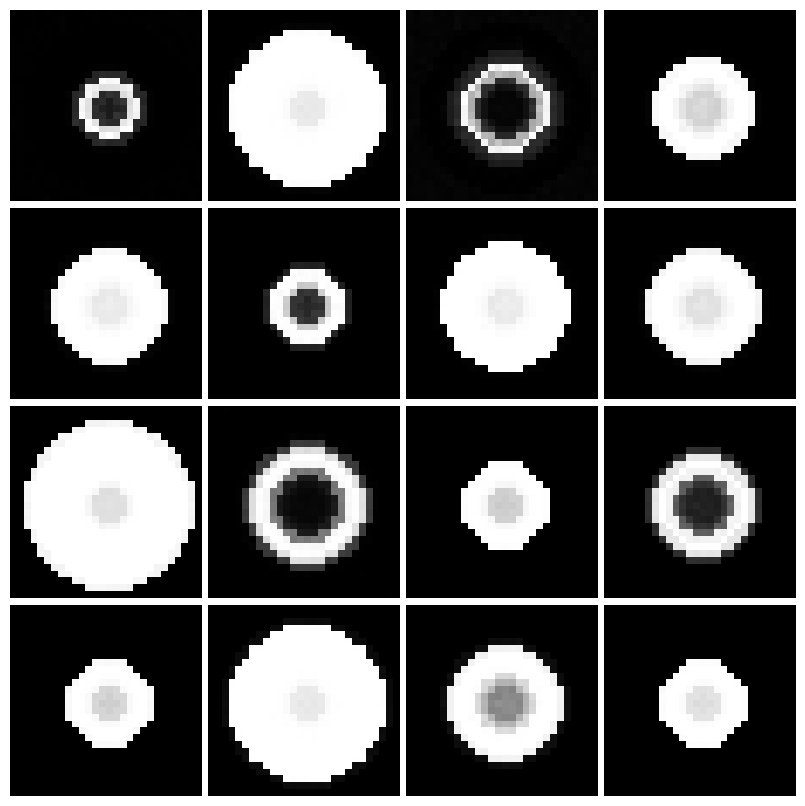

In [17]:
reconstructions = trained_model.reconstruct(eval_dataset[:25].to(device)).detach().cpu()

plot_grid(reconstructions)

# INTERPOLATIONS

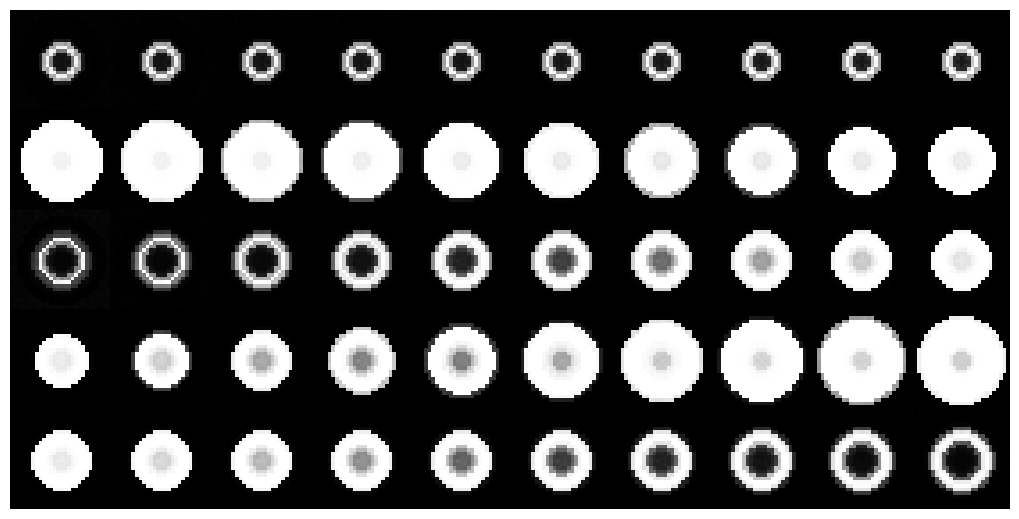

In [18]:
interpolations = trained_model.interpolate(eval_dataset[:5].to(device), eval_dataset[5:10].to(device), granularity=10).detach().cpu()

fig, axes = plt.subplots(nrows=5, ncols=10, figsize=(10, 5))

for i in range(5):
    for j in range(10):
        axes[i][j].imshow(interpolations[i, j].cpu().squeeze(0), cmap='gray')
        axes[i][j].axis('off')
plt.tight_layout(pad=0.)

# GENERATE

### Metrics

In [19]:
from torchmetrics.image.fid import FrechetInceptionDistance
from torchmetrics.image.inception import InceptionScore

# FID score computation class
fid_calculator = FrechetInceptionDistance(feature=64, reset_real_features=False, normalize=True)
fid_calculator.update(train_dataset.expand(train_dataset.shape[0], 3, 28, 28)[:200,].to('cpu'), real=True)

# IS score computation class
is_calculator = InceptionScore(normalize=True)

def compute_fid_score(gen_data):
    # Lower is better
    # greater sample variety
    fid_calculator.update(gen_data.expand(gen_data.shape[0], 3, 28, 28).cpu(), real=False)
    fid_score = fid_calculator.compute().item()
    print(f"FID = {fid_score:.4f}")
    return fid_score

def compute_is_score(gen_data):
    # Higher is better
    # better quality within individual images
    is_calculator.update(gen_data.expand(gen_data.shape[0], 3, 28, 28).cpu())
    is_score = is_calculator.compute()
    print(f"IS [mean] = {is_score[0].item():.4f}")
    print(f"IS [std] = {is_score[1].item():.4f}")


/home/dmandach/miniconda3/envs/py310/lib/python3.10/site-packages/torchmetrics/utilities/prints.py:43: UserWarning: Metric `InceptionScore` will save all extracted features in buffer. For large datasets this may lead to large memory footprint.
  warnings.warn(*args, **kwargs)  # noqa: B028


## Generators

### Normal Sampler

In [20]:
from pythae.samplers import NormalSampler

sampler = NormalSampler(
    model=trained_model,
    sampler_config=None
)
gen_data = sampler.sample(
    num_samples=25,
)

FID = 1.7735
IS [mean] = 1.5587
IS [std] = 0.4473


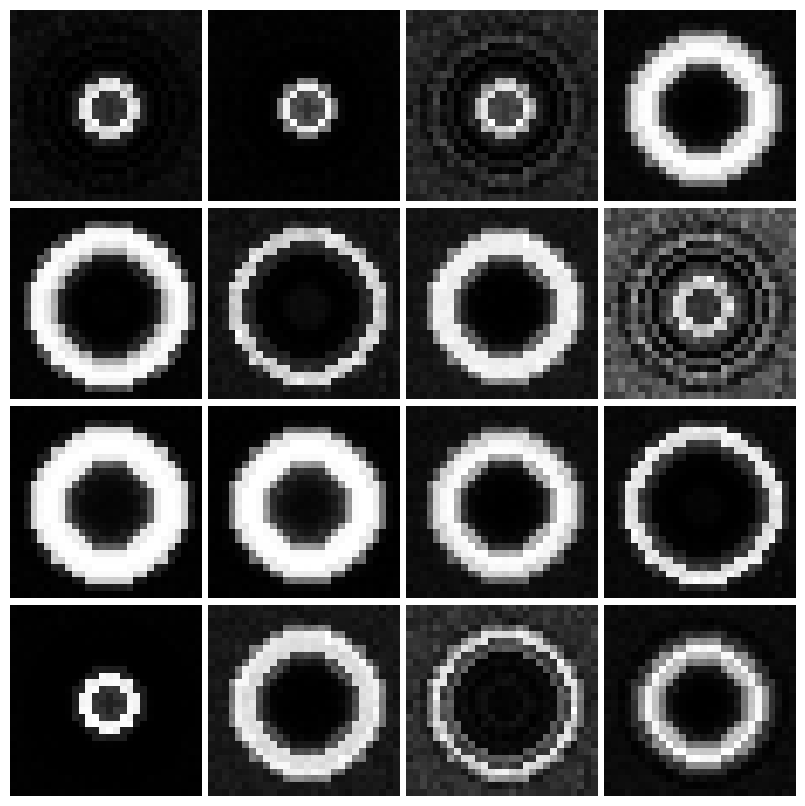

In [21]:
plot_grid(gen_data.data.cpu())
compute_fid_score(gen_data)
compute_is_score(gen_data)

### Gaussian Mixture Model Sampler

In [22]:
from pythae.samplers import GaussianMixtureSampler, GaussianMixtureSamplerConfig


gmm_sampler_config = GaussianMixtureSamplerConfig(
    n_components=2
)

gmm_sampler = GaussianMixtureSampler(
    sampler_config=gmm_sampler_config,
    model=trained_model
)

gmm_sampler.fit(
    train_data=train_dataset
)

gmm_gen_data = gmm_sampler.sample(
   num_samples=25
)

FID = 0.7269
IS [mean] = 1.9826
IS [std] = 0.2295


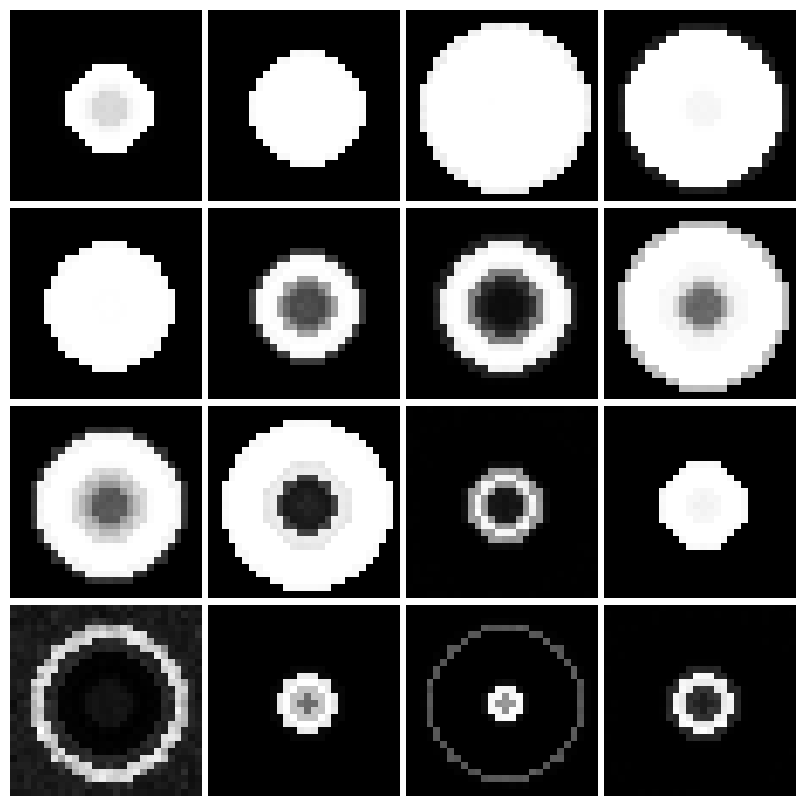

In [23]:
plot_grid(gmm_gen_data.data.cpu())
compute_fid_score(gmm_gen_data)
compute_is_score(gmm_gen_data)

### RHVAE Sampler

In [24]:
from pythae.samplers import RHVAESampler, RHVAESamplerConfig

rh_sampler_config = RHVAESamplerConfig(
    mcmc_steps_nbr = 100,
    n_lf = 15,
    eps_lf = 1e-3,
    beta_zero = 0.3
)

rh_sampler = RHVAESampler(
    sampler_config=rh_sampler_config,
    model=trained_model
)

rh_sampler.fit(
    train_data=train_dataset
)

rh_gen_data = rh_sampler.sample(
   num_samples=25
)

FID = 0.4645
IS [mean] = 2.0730
IS [std] = 0.2895


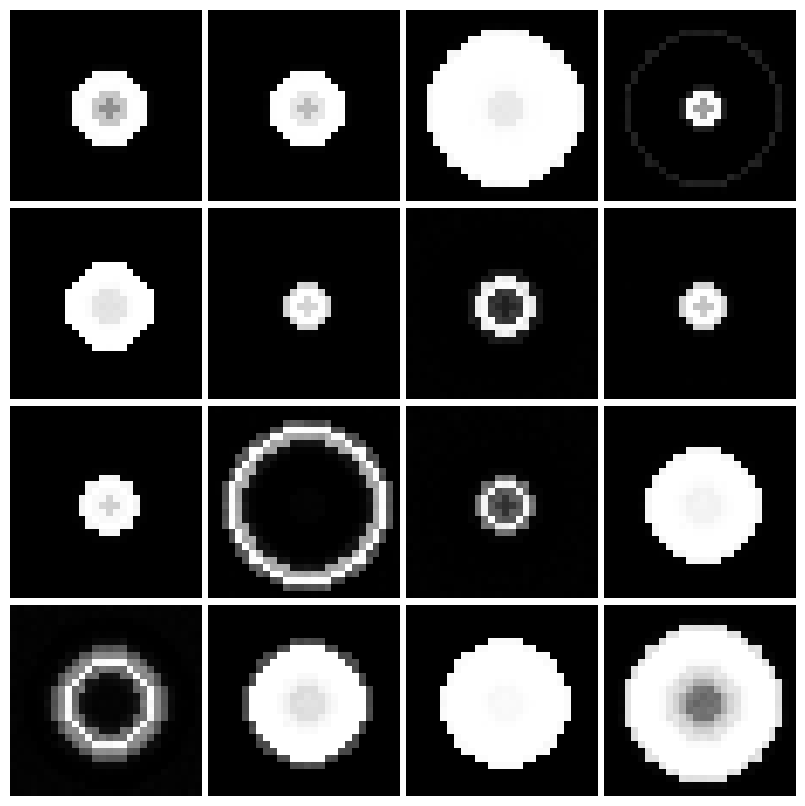

In [25]:
plot_grid(rh_gen_data.cpu())
compute_fid_score(rh_gen_data)
compute_is_score(rh_gen_data)